In [273]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
import pickle, gzip, urllib.request, json
from google.colab import drive

In [395]:
# To ensure reproducibility
random.seed(11)
np.random.seed(11)

# To connect to google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [396]:
# Load the dataset
path = '/content/drive/MyDrive/Colab Notebooks/ECSE549 - A2/mnist.pkl.gz'
with gzip.open(path, 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

# Get the data into arrays
images = train_set[0]
labels = train_set[1]
print(labels.shape)
print(images.shape)

# Put aside an array for the patterns
patterns = np.zeros((10,784))

# Set aside one image per class to store (10 images in total)
for category in range(10):
  inclass = [i for i in range(labels.shape[0]) if labels[i] == category]
  patterns[category,:] = 1.0*(images[inclass[random.randint(0,len(inclass))],:] > 0)


print(patterns.shape)

(50000,)
(50000, 784)
(10, 784)


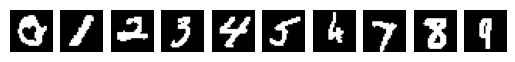

1.0 0.0


In [397]:
#Plot the patterns we're going to store
fig, axs = plt.subplots(1,10)
for c in range(10):
    axs[c].imshow(patterns[c,:].reshape((28,28)), cmap='gray')
    axs[c].axis("off")
plt.show()

# check the max and min pixel value
print(patterns[0,:].max(), patterns[0,:].min())


In [630]:
from ast import JoinedStr
import numpy as np

class HopfieldNetwork:
    def __init__(self, N, epochs):
        """
        Method to initiate the basic hopfield network

        Notes:
         - N is the number of units
         - State represents the current network
         - Weight is the NxN weight matrix
         - Threshold is the Nx1 threshold vector
         - epochs is the number of epochs to run the network for (rather than running update multiple times)
        """
        self.N = N
        self.epochs = epochs
        self.patternStored = []
        self.weight = np.zeros((N, N), dtype=float)
        self.state = np.zeros(N, dtype=float)
        self.threshold = np.zeros(N, dtype=float)

    def set_state(self, activity):
        """
        set_state(activity)

        Sets the state of the network to the pattern given by activity.

        You do not need to change this function.
        """
        self.state = np.array(activity)

    # NOTE I CHANGED THE CODE HERE SO THAT EPOCHS ARE A FUNCTION OF NETWORK
    def update(self):
        """
        This function computes the activations at each time step.
        We spike when our net function outputs something greater than 0,
        and vice versa when not to spike.
        Implements a synchronous update function.
        """
        states_over_time = [self.state.copy()]

        for i in range(self.epochs):
            # We are gonna go through each neuron and update it's weight so initialize to 0
            state_copy = np.zeros(self.N)
            for j in range(self.N):
                # Dot product of weights for neuron j with the copied state minus threshold
                net_input = np.dot(self.weight[j], self.state) - self.threshold[j]
                # bipolar representation, np.sign caused boolean values
                if net_input > 0:
                    state_copy[j] = 1
                else:
                    state_copy[j] = -1

            self.set_state(state_copy.copy())
            states_over_time.append(state_copy.copy())
        return states_over_time


    def store_one(self, image, c=1):
        """
        Stores one pattern in the hopfield network
        Hebbs learning is used to update the weights with C being a constant set to 1
        """
        # Using the equation learned in slides we multiply the image by its transpose
        # Scaling factor to normalize
        if self.patternStored is not None:
          # self.weight = (len(self.patternStored)) * self.weight
          self.weight += c * np.outer(image, image)  # Shape (784, 784)
          self.patternStored.append(image)
          # Normalize the weight
          self.weight /= len(self.patternStored)
        else:
          temp_weight = c * np.outer(image, image)  # Shape (784, 784)
          self.patternStored = [image]


        np.fill_diagonal(self.weight, 0)

        return self.weight

    def store_multi(self, images, eta=0.0001):
        """
        Using a similar line of thinking now we are dealing with an array of images,
        so we will use hebbian learning and implement it find the outer product of each
        image. We can call store_one or impelement it here
        """

        # reintialize weights
        self.weight = np.zeros((self.N, self.N))
        self.patternStored = []
        self.threshold = np.zeros(self.N)

        # center image
        norm = np.sum([np.sum(image) for image in images]) / (self.N * images.shape[0])
        # norm = 0
        for img in images:
            self.patternStored.append(img)
            reshape_image = img - norm
            # Find outer product of each image and sum it to the weight
            self.weight += eta * np.outer(img, img)
            # Find thresholds values
            self.threshold -= 0.001 * np.dot(self.weight, img)
            print("weight",self.weight.shape)
            print(self.threshold.shape)

        # Normalize the weights
        self.weight /= images.shape[0]
        np.fill_diagonal(self.weight, 0)

        return self.weight

In [616]:
# Some helper functions for generating test images

# The function for generating a noisy version of an image
def image_noise(image,noise_level=0.1):
    """
    new_image = test_noise(image)

    This function takes an image, adds noise to it, and returns it.

    noise_level - between 0-1, try experimenting with this

    """

    # create a mask for adding noise to the image
    # had to change random.uniform to np.random.uniform
    image_mask = np.random.uniform(size=image.shape) < noise_level

    return np.logical_xor(image,image_mask)

# The function for generating a combo of two images
def image_combo(image1,image2,image1_weight=0.5):
    """
    newimage = test_combo(image1,image2)

    This function takes a pair of images, combines them, and returns the result.

    image1_weight - between 0-1, try experimenting with this

    """

    # create a mask for mixing the images
    image1_mask = np.random.uniform(size=image1.shape) < image1_weight

    return image1_mask*image1 + (1-image1_mask)*image2

# Since we are using pattern as 1,-1 we should convert images to that scale 0,1
def convert_image(image):
    # If it's a 1, then 2*1 - 1 = 1, if 2*0 - 1 = -1 from leetcode lol
    return 2 * np.array(image,int) -1

# Since we are using pattern as 1,-1 we should convert back to a 0-1 scale
def convert_patterns(patterns):
    patterns[patterns == -1] = 0
    return patterns

weight (784, 784)
(784,)
weight (784, 784)
(784,)


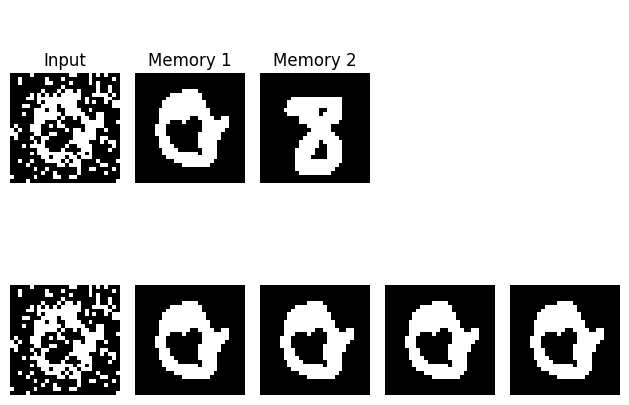

In [640]:
# Create a Hopfield network and train it

numsteps = 5 # feel free to change this


one_pattern = False # flag for whether to store one pattern at a time

# Random indices to pick two random images
image_indices = np.random.choice(len(patterns),size=2,replace=False)

# number of time-steps to run the network for is the last parameter
hnet = HopfieldNetwork(784, numsteps) # construct the network

# Convert the images to a bipolar pattern
patterns_picked = patterns[image_indices]
patterns_converted = np.vectorize(convert_image)(patterns_picked)


if one_pattern:
    # Train the network to store all the patterns using your store_one function
    # Show working for two patterns as per instructions
    for image in patterns_converted:
      hnet.store_one(image)
else:
    # grab two random images because otherwise it wont work
    hnet.store_multi(patterns_converted)


# create an array for storing activity states over time
# test using a noisy version of a random image
rand_image = patterns[image_indices[0],:]

# Convert the noisy image into a bipolar pattern
noisy_image = convert_image(image_noise(rand_image, noise_level=0.2))

# Set state
hnet.set_state(noisy_image)

# Find the activities
activities = hnet.update()


# plot the results
fig, axs = plt.subplots(2,numsteps)
axs[0,0].imshow(noisy_image.reshape((28,28)), cmap='gray')
axs[0,0].set_title('Input')
for i,img in enumerate(patterns_converted):
  axs[0,i+1].imshow(img.reshape((28,28)), cmap='gray')
  axs[0,i+1].set_title(f'Memory {i+1}')

for c in range(numsteps):
    axs[1,c].imshow(activities[c].reshape((28,28)), cmap='gray')
    axs[0,c].axis("off")
    axs[1,c].axis("off")

fig.tight_layout()
plt.show()


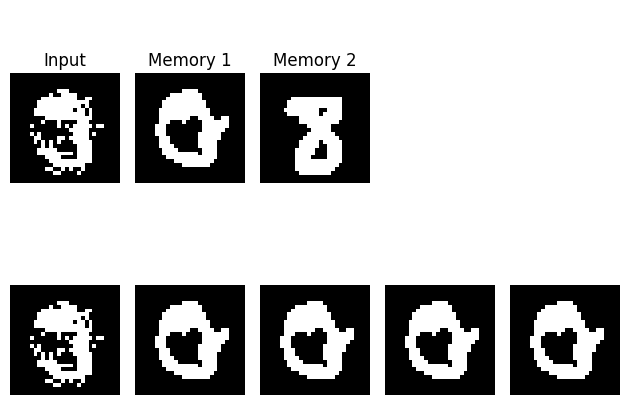

In [641]:
# test using a noisy version of a random image
rand_image1 = patterns_picked[0]

rand_image2 = patterns_picked[1]

activity = convert_image(image_combo(rand_image1,rand_image2))

hnet.set_state(activity)
activities = hnet.update()


# plot the results
fig, axs = plt.subplots(2,numsteps)
axs[0,0].imshow(activity.reshape((28,28)), cmap='gray')
axs[0,0].set_title('Input')
for i,img in enumerate(patterns_converted):
  axs[0,i+1].imshow(img.reshape((28,28)), cmap='gray')
  axs[0,i+1].set_title(f'Memory {i+1}')


for c in range(numsteps):
    axs[1,c].imshow(activities[c].reshape((28,28)), cmap='gray')
    axs[0,c].axis("off")
    axs[1,c].axis("off")

fig.tight_layout()
plt.show()

